In [1]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import tensorflow as tf

from src.model import *

In [2]:
out_dir = '../results/res_target'
res_target_path = '../data/real_data/resTargetZ_1.mat'


os.makedirs(out_dir, exist_ok=True)

# Preprocess resolution target for prediction

In [3]:
res = sio.loadmat(res_target_path)['b']
res = normalize(res).T
res = res.astype(np.float16)[np.newaxis, ..., np.newaxis]

# Test Models

## UNet, 9 Learnable Wiener Deconvolutions

In [4]:
psfs = np.zeros((648, 486, 9))
Ks = np.zeros((1, 1, 9))
model = UNet_multiwiener_resize(648, 486, psfs, Ks,
                         encoding_cs=[24, 64, 128, 256, 512, 1024],
                         center_cs=1024,
                         decoding_cs=[512, 256, 128, 64, 24, 24],
                         skip_connections=[True, True, True, True, True, False])


model.load_weights('../models/multiwiener_unet/multiwiener_unet')
pred_multi = np.clip(model(res), 0, 1).squeeze()

## UNet, 1 Learnable Wiener Deconvolution

In [5]:
psf = np.zeros((648, 486))
K = 0
model = UNet_wiener(648, 486, psf, K, 
                         encoding_cs=[24, 64, 128, 256, 512, 1024],
                         center_cs=1024,
                         decoding_cs=[512, 256, 128, 64, 24, 24],
                         skip_connections=[True, True, True, True, True, False])

model.load_weights('../models/wiener_unet/wiener_unet')
pred_single = np.clip(model(res), 0, 1).squeeze()

# Basic UNet

In [6]:
model = UNet(648, 486,
                 encoding_cs=[24, 64, 128, 256, 512, 1024],
                 center_cs=1024,
                 decoding_cs=[512, 256, 128, 64, 24, 24],
                 skip_connections=[True, True, True, True, True, False])

model.load_weights('../models/basic_unet/basic_unet')
pred_unet = np.clip(model(res), 0, 1).squeeze()

# FISTA

In [7]:
# pred_fista = sio.loadmat('../results/best_images/recons/recon_res_target.mat')['xhat_out']

# Side-by-side

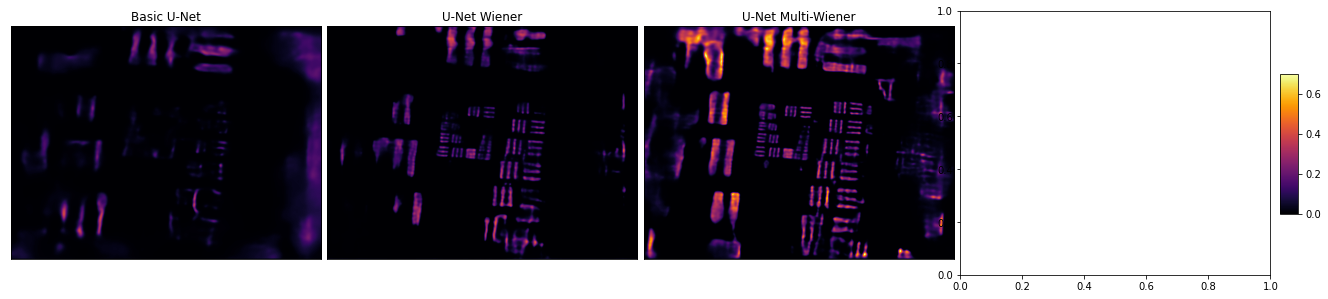

In [8]:
fig, axs = plt.subplots(1,4,figsize=(648*4*0.01,486*0.01))

im = axs[0].imshow(pred_unet.T, vmin=0, vmax=0.7, cmap='inferno')
im = axs[1].imshow(pred_single.T, vmin=0, vmax=0.7, cmap='inferno')
im = axs[2].imshow(pred_multi.T, vmin=0, vmax=0.7, cmap='inferno')
# im = axs[3].imshow(pred_fista, vmin=0, vmax=0.5, cmap='inferno')

axs[0].set_title('Basic U-Net')
axs[1].set_title('U-Net Wiener')
axs[2].set_title('U-Net Multi-Wiener')
# axs[3].set_title('FISTA')

axs[0].set_xticks([])
axs[1].set_xticks([])
axs[2].set_xticks([])
# axs[3].set_xticks([])

axs[0].set_yticks([])
axs[1].set_yticks([])
axs[2].set_yticks([])
# axs[3].set_yticks([])
    
plt.subplots_adjust(wspace=0.02, hspace=0.02)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.3, 0.01, 0.4])
plt.colorbar(im, cax=cbar_ax)

# plt.tight_layout()
plt.savefig('../results/res_comparisons.png', facecolor='white', transparent=False)
plt.show()
# plt.close('all')